In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

from tensorboard.plugins.hparams import api as hp

In [8]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([8,16,32,64])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([8,16,32]))
#HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

n = 26
# Set forecasting window length (in years)
m = 13
# Set annual sampling rate
f = 12 

freq = 12
h = m*f
n_steps = 12

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def train_test_split_ts_2d_raw(X, h):
    return(X[:-h],X[-h:])

rmse_list = []
for i in range(6):
    file_name ="../extreme_data/SPI12_{}.csv".format(i) 
    data = pd.read_csv(file_name)
    
    x = data.iloc[1:,1].values
    oni = data.iloc[1:,2].values
    

    
    #raw_seq = x[index:index+(n+m)*f]
    X, y = split_sequence(x, n_steps)

    X_oni, _ = split_sequence(oni, n_steps)

    X = np.hstack((X_oni,X))

    #X = (X - X.mean(0))/X.std(0)

    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)

    def train_test_model(hparams):
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
            layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
            layers.Dropout(0.1),
            layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
            layers.Dense(1)
        ])

        model.compile(optimizer=hparams[HP_OPTIMIZER],
                    loss='mean_squared_error',
                    metrics=['RootMeanSquaredError'])

        model.fit(x_train, y_train, epochs=100,verbose=False) 
        _, rmse = model.evaluate(x_test, y_test, verbose=False)
        return rmse

    def run( hparams):
        #with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values us`iied in this trial
        rmse = train_test_model(hparams)
        #    tf.summary.scalar(METRIC_RMSE, rmse, step=1)
        return(rmse, hparams)

    session_num = 0
    min_rmse = float('inf')
    best_hparams = {}
    for num_units1 in HP_NUM_UNITS1.domain.values:
        for num_units2 in HP_NUM_UNITS2.domain.values:
            #for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        #HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    #print('--- Starting trial: %s' % run_name)
                    #print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run(hparams)
                    if ~np.isnan(rmse) and rmse < min_rmse: 
                        best_hparams = current_hparams
                        min_rmse = rmse
                    session_num += 1

    #params = list(best_hparams.values())
    rmse_list.append(min_rmse)
    #result_list.append(np.array(rmse_list).mean())

#`iinp.save("SPIWithONI_NoNormal.npy",np.array(rmse_list))
    

KeyboardInterrupt: 

In [10]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [11]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def train_test_split_ts_2d_raw(X, h):
    return(X[:-h],X[-h:])


def train_test_split_ts(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

In [12]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size)]
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

In [13]:
def forecast(first_item, model, h, n_step):
    x = first_item
    result = []
    #x = np.reshape(x,(1,20))
    for i in range(h):
        y = model.predict(np.reshape(x,(1,n_step*2)))
        result.append(y)
        x = np.append(x[1:],np.array(y))
    return(np.array(result))   

In [14]:
def build_model(n_steps, n_units, learning_rate, optimizer_name):
    model = keras.Sequential()
    if len(n_units) == 1:
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
    else:  
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
        for i in range(1,len(n_units)):
            model.add(layers.Dense(n_units[i], activation=tf.nn.relu))
    
    model.add(layers.Dense(1))
    
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [15]:
def cv_hparam_tunning(x, n_steps, num_units, optimizer, learning_rate,
                      training_window=15, forecast_window=1, freq=12,epochs=1):

    fuzzify(x)
    L = len(x)
    errors = []
    
    for i in range(0, L - (training_window+forecast_window)*freq, freq):   

        raw_seq = x[i:i+(training_window + forecast_window)*freq]

        X, y_test = train_test_split_ts_2d_raw(raw_seq, forecast_window*freq) 
        X_train, y_train = split_sequence(X, n_steps)

        #estimator = KerasRegressor(build_fn=baseline_ model(n_steps), epochs=100, batch_size=5, verbose=0)
        model = build_model(n_steps, num_units, learning_rate, optimizer)


        #EPOCHS = 100
        model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

        y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, freq, n_steps)
        y_hat = np.reshape(y_hat,len(y_test))
        if np.any(np.isnan(y_hat)):
            errors.append(np.nan)
        else:
            errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

        #errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))
        
    return(np.nanmean(errors))

In [16]:
def uni_deseasonalize(ts,freq=12):
    ts = np.array(ts)
    avgs = np.zeros(freq)
    stds = np.zeros(freq)
    N = len(ts)
    #averages = np.zeros((freq,n))
    temp = ts
    result = np.zeros((N))
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        avgs[j] = temp[Idx].mean()
        stds[j] = temp[Idx].std()
        result[Idx] = (temp[Idx] - temp[Idx].mean())#/temp[Idx].std()
    return(result, avgs) 

In [17]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'data.npy'

In [339]:
x = data[27,6,]

In [25]:
data = pd.read_csv("../extreme_data/raw12_5.csv")

In [26]:
x = data.iloc[1:,1].values
oni = data.iloc[1:,2].values

In [20]:
x = np.array(data.iloc[1:,1:].values)
oni = np.array(data.iloc[1:,2:].values)

In [27]:
n = 26
# Set forecasting window length (in years)
m = 13
# Set annual sampling rate
f = 12 
L = x.shape[0]
errors = []
j = 0


start = 1977
origin = 1977
# Set annual sampling rate
freq = 12
h = m*f
n_steps = 12

index = (origin - start) * f

In [28]:
raw_seq = x[index:index+(n+m)*f]
X, y = split_sequence(raw_seq, n_steps)

In [29]:
oni_seq = oni[index:index+(n+m)*f]
X_oni, _ = split_sequence(oni_seq, n_steps)

In [30]:
X = np.hstack((X_oni,X))

In [31]:
X_norm = (X - X.mean(0))/X.std(0)

In [32]:
x_train, x_test = train_test_split_ts_2d_raw(X, h)
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [75]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4,8,16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4,8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                    if (~np.isnan(rmse)) and (rmse < min_rmse): 
                        best_hparams = current_hparams
                        min_rmse = rmse
                        print("mis_rmse {}".format(min_rmse))
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 532us/sample - loss: 11.2444 - RootMeanSquaredError: 3.3516
mis_rmse 3.351649284362793
--- Starting trial: run-1
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
156/156 [==============================] - 0s 419us/sample - loss: 73.4387 - RootMeanSquaredError: 8.5693
--- Starting trial: run-2
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 404us/sample - loss: 37.2455 - RootMeanSquaredError: 6.0995
--- Starting trial: run-3
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 412us/sample - loss: 14.1517 - RootMeanSquaredError: 3.7607
--- Starting trial: run-4
{'num_units 1': 4, 

156/156 [==============================] - 0s 429us/sample - loss: 103.4627 - RootMeanSquaredError: 6.0475
--- Starting trial: run-36
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 396us/sample - loss: 10.9165 - RootMeanSquaredError: 3.3010
--- Starting trial: run-37
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
156/156 [==============================] - 0s 396us/sample - loss: 9.9839 - RootMeanSquaredError: 3.1567
mis_rmse 3.1567482948303223
--- Starting trial: run-38
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 389us/sample - loss: 39856.2599 - RootMeanSquaredError: 6.0481
--- Starting trial: run-39
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
156/156 [============================

156/156 [==============================] - 0s 537us/sample - loss: 10.6927 - RootMeanSquaredError: 3.2657
--- Starting trial: run-71
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 416us/sample - loss: 1591653857002258432.0000 - RootMeanSquaredError: 6.0210


In [ ]:
!rm -rf ./logs/

In [82]:
%reload_ext tensorboard

In [83]:
%tensorboard --logdir logs/hparam_tuning

In [94]:
min_rmse

3.1313617

In [95]:
list(best_hparams.values())

[16, 8, 0.1, 0.001, 'RMSprop']

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
])

In [34]:
model.compile(optimizer="RMSProp",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

In [35]:
model.fit(x_train, y_train, epochs=100, verbose=False) 

_, rmse = model.evaluate(x_test, y_test)

156/156 [==============================] - 0s 467us/sample - loss: 2.7024 - RootMeanSquaredError: 1.6356


In [36]:
predictions = model.predict(x_test)

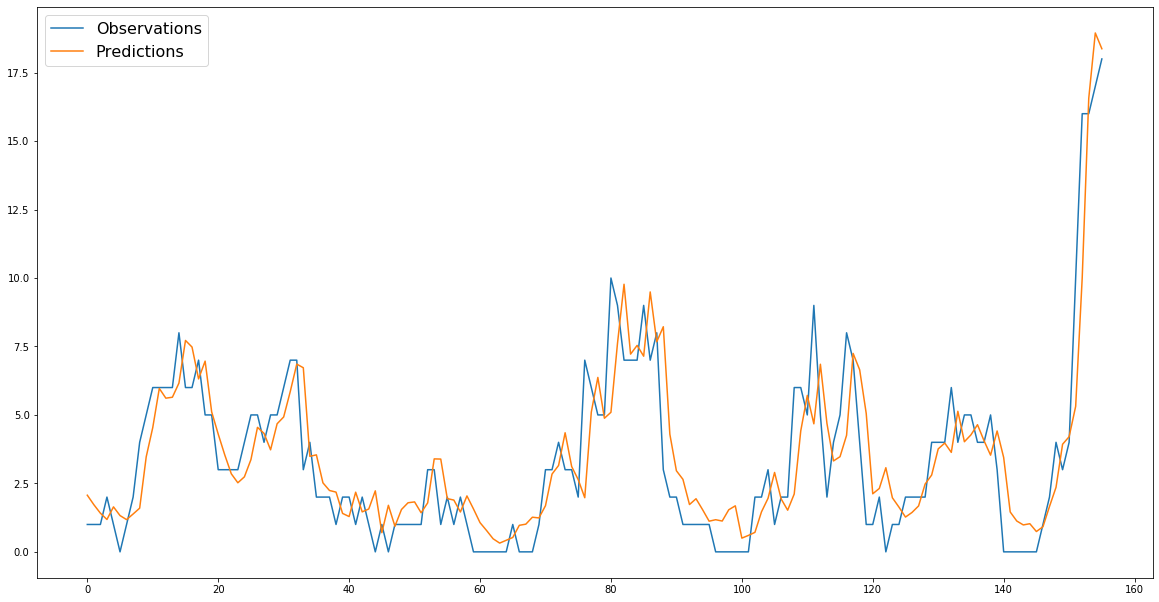

In [37]:
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend(fontsize = 16)

(0, 20)

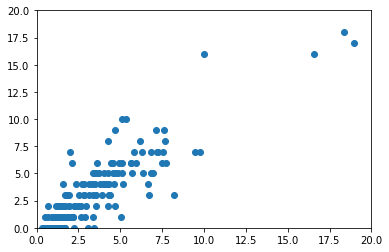

In [38]:
plt.scatter(predictions, y_test)
plt.xlim((0,20))
plt.ylim((0,20))

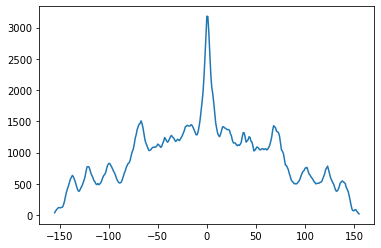

In [46]:
predictions = np.squeeze(predictions)
c = np.correlate(predictions,y_test, "full")

x_c = np.arange(-len(predictions)+1,len(predictions))

plt.plot(x_c,c)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.37886879, 0.39153811, 0.41555659, 0.44496189, 0.48501517,
        0.5278433 , 0.57545229, 0.64484262, 0.73752652, 0.84176519,
        0.9387246 , 0.93777078, 0.86253852, 0.76332735, 0.66535143,
        0.60293602, 0.57311935, 0.53147553, 0.48180046, 0.43573547,
        0.40903594]),
 <matplotlib.lines.Line2D at 0x7fb7f80d5898>)

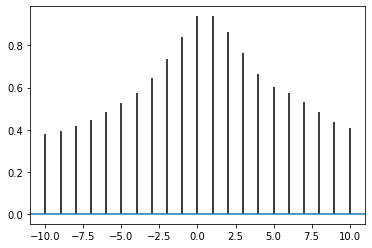

In [47]:
plt.xcorr(predictions,y_test)

In [424]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(4, activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, activation=tf.nn.relu),
    layers.Dense(1)
])

In [431]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dense(1)
])

In [432]:
model.compile(optimizer="RMSProp",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

In [436]:
model.fit(x_train, y_train, epochs=100, verbose=False) 

_, rmse = model.evaluate(x_test, y_test)

48/48 [==============================] - 0s 65us/sample - loss: 18.1600 - RootMeanSquaredError: 4.2500


In [434]:
rmse

4.4760284

In [428]:
predictions = model.predict(x_test)

In [429]:
math.sqrt(mean_squared_error(y_test,predictions))

4.093961828487743

In [22]:
y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

math.sqrt(mean_squared_error(y_test,y_hat))

1.3121330443779999e+32

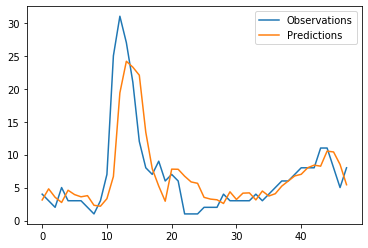

In [430]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend()

In [367]:
y_test

array([ 4,  3,  2,  5,  3,  3,  3,  2,  1,  3,  7, 25, 31, 27, 21, 12,  8,
        7,  9,  6,  7,  6,  1,  1,  1,  2,  2,  2,  4,  3,  3,  3,  3,  4,
        3,  4,  5,  6,  6,  7,  8,  8,  8, 11, 11,  8,  5,  8])

In [368]:
predictions

array([[ 4.3304925],
       [ 4.1157084],
       [ 4.510546 ],
       [ 2.1828644],
       [ 4.7701654],
       [ 4.578716 ],
       [ 4.109888 ],
       [ 3.4815905],
       [ 3.6134114],
       [ 2.4285672],
       [ 2.6691763],
       [ 6.6833134],
       [20.75802  ],
       [29.71366  ],
       [26.457047 ],
       [21.636944 ],
       [15.348185 ],
       [ 8.876786 ],
       [ 4.997763 ],
       [ 6.7743354],
       [ 6.659576 ],
       [ 7.1900506],
       [ 5.728469 ],
       [ 4.671945 ],
       [ 4.2929974],
       [ 3.7907398],
       [ 3.4014685],
       [ 2.4700365],
       [ 2.674887 ],
       [ 2.8462791],
       [ 4.8797803],
       [ 4.3375816],
       [ 4.7033877],
       [ 5.591171 ],
       [ 5.25372  ],
       [ 4.1358533],
       [ 4.576705 ],
       [ 5.8609815],
       [ 6.9745603],
       [ 6.513139 ],
       [ 7.410751 ],
       [ 8.147883 ],
       [ 8.272674 ],
       [ 7.422599 ],
       [ 8.93429  ],
       [10.05007  ],
       [ 7.4488416],
       [ 5.80

In [115]:
df_oni = pd.DataFrame(x,
                  columns=["number"],
                  index=pd.date_range("19770101", periods=len(x), freq='MS'))

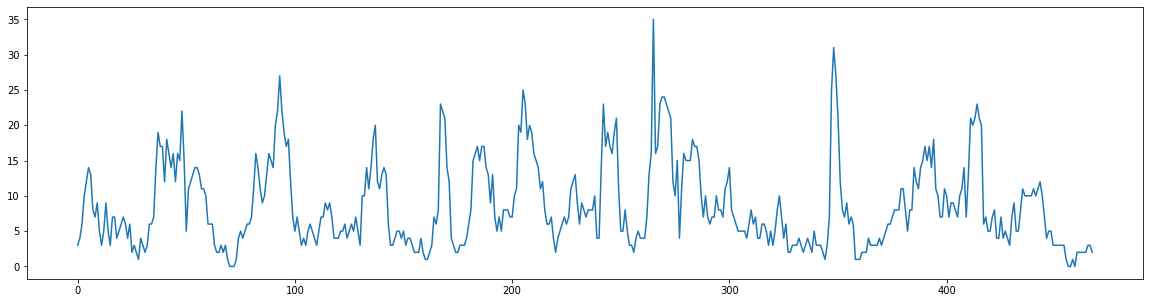

In [117]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(x)

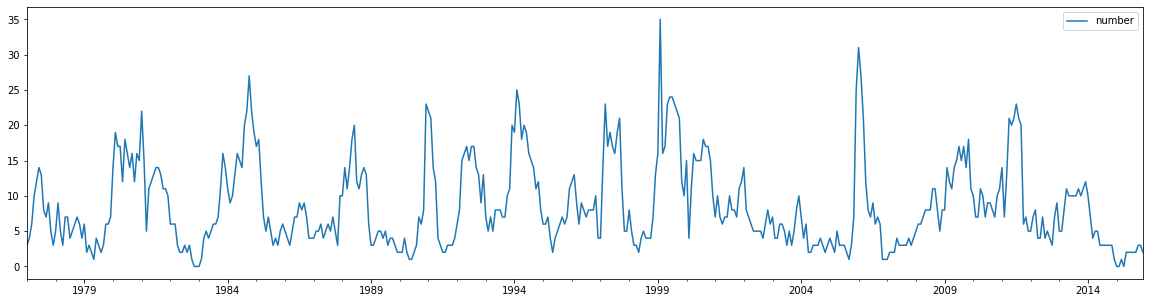

In [118]:
df_oni.plot()

In [114]:
df_oni

,number
1970-01-01 00:00:00.000001980,3
1970-02-01 00:00:00.000001980,4
1970-03-01 00:00:00.000001980,6
1970-04-01 00:00:00.000001980,10
1970-05-01 00:00:00.000001980,12
...,...
2008-08-01 00:00:00.000001980,2
2008-09-01 00:00:00.000001980,2
2008-10-01 00:00:00.000001980,3
2008-11-01 00:00:00.000001980,3


In [38]:
raw_seq = x[index:index+(n+m)*f,:]

In [14]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
#X, avgs = uni_deseasonalize(X)
x_train, y_train = split_sequence(X, n_steps)

In [15]:
x_test, y_test = split_sequence(y_test, n_steps)

In [65]:
X_train, y_train = split_sequence(X[:,0], n_steps)

In [66]:
oni_x = np.reshape(X[19:-1,1], (X_train.shape[0],1))
oni_y = np.reshape(X[19:-1,1], (X_train.shape[0],1))

In [67]:
X_train = np.hstack((oni_x, X_train))

In [ ]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
#X, avgs = uni_deseasonalize(X)

X_train, y_train = split_sequence(X, n_steps)

In [86]:
raw_seq = x[index:index+(n+m)*f]

In [87]:
X, y = split_sequence(raw_seq, n_steps)

In [88]:
x_train, x_test = train_test_split_ts_2d_raw(X, h)

In [89]:
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [55]:
n_units = [16]
learning_rate = 0.001
optimizer = 'adam'
epochs = 100

In [59]:
n_units = [200,100,50,30,20,10]
learning_rate = 0.001
optimizer = 'adam'
epochs = 500

In [60]:
model = build_model(n_steps, n_units, learning_rate, optimizer)
model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [116]:
#avgs = np.tile(avgs, int(len(y_hat)/f))
#stds = np.tile(stds, int(len(y_hat)/f))

In [61]:
math.sqrt(mean_squared_error(y_test,y_hat))

8.306955666928031

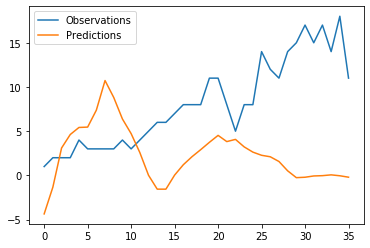

In [58]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [112]:
y_test

array([ 1,  2,  2,  2,  4,  3,  3,  3,  3,  4,  3,  4,  5,  6,  6,  7,  8,
        8,  8, 11, 11,  8,  5,  8,  8, 14, 12, 11, 14, 15, 17, 15, 17, 14,
       18, 11])

In [ ]:
if np.any(np.isnan(y_hat)):
    errors.append(np.nan)
else:
    errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

In [29]:
%load_ext tensorboard

In [30]:
!rm -rf ./logs/ 

In [371]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

In [373]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = n_steps *2 ),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1),
    ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mean_squared_error',
      metrics=['RootMeanSquaredError'],
    )

    model.fit(x_train, y_train, epochs=100,verbose=False) # Run with 1 epoch to speed things up for demo purposes
    _, rmse = model.evaluate(x_test, y_test)
    return rmse


In [374]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=10)

In [375]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1



--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
48/48 [==============================] - 0s 1ms/sample - loss: 19.1536 - RootMeanSquaredError: 4.3765
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
48/48 [==============================] - 0s 1ms/sample - loss: 47.7244 - RootMeanSquaredError: 6.9083
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
48/48 [==============================] - 0s 1ms/sample - loss: 18.5791 - RootMeanSquaredError: 4.3103
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'sgd'}
48/48 [==============================] - 0s 1ms/sample - loss: 47.5877 - RootMeanSquaredError: 6.8984
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
48/48 [==============================] - 0s 1ms/sample - loss: 21.7139 - RootMeanSquaredError: 4.6598
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
48/48 [

In [23]:
!kill 27181

In [253]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 28404), started 7:23:30 ago. (Use '!kill 28404' to kill it.)

In [59]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4,8,16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4,8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

In [60]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

In [61]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

In [62]:
session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                    if (~np.isnan(rmse)) and (rmse < min_rmse): 
                        best_hparams = current_hparams
                        min_rmse = rmse
                        print("mis_rmse {}".format(min_rmse))
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 449us/sample - loss: 17.8580 - RootMeanSquaredError: 4.2251
mis_rmse 4.225065231323242
--- Starting trial: run-1
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
156/156 [==============================] - 0s 412us/sample - loss: 10.4366 - RootMeanSquaredError: 3.2289
mis_rmse 3.228870153427124
--- Starting trial: run-2
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 407us/sample - loss: 41.9251 - RootMeanSquaredError: 6.0395
--- Starting trial: run-3
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 419us/sample - loss: 15.8140 - RootMeanSquaredError: 3.9760
--- Starting trial

156/156 [==============================] - 0s 487us/sample - loss: 40.0987 - RootMeanSquaredError: 6.0327
--- Starting trial: run-36
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 413us/sample - loss: 10.9880 - RootMeanSquaredError: 3.3129
--- Starting trial: run-37
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
156/156 [==============================] - 0s 472us/sample - loss: 11.7133 - RootMeanSquaredError: 3.4203
--- Starting trial: run-38
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 569us/sample - loss: 46.9215 - RootMeanSquaredError: 6.0434
--- Starting trial: run-39
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 514us/sample - loss: 1

156/156 [==============================] - 0s 449us/sample - loss: 12.0740 - RootMeanSquaredError: 3.4720
--- Starting trial: run-71
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 404us/sample - loss: 1240754091246746171604992.0000 - RootMeanSquaredError: 29829.9004


In [64]:
list(best_hparams.values())

[16, 4, 0.3, 0.01, 'RMSprop']

In [69]:
min_rmse

3.0939493

In [58]:
!rm -rf ./logs/ 

In [57]:
!kill 3869

In [66]:
%reload_ext tensorboard

In [67]:
%tensorboard --logdir logs/hparam_tuning

In [443]:
for key in best_hparams.keys():
    print(key)

<HParam 'num_units 1': {4, 8, 16}>
<HParam 'num_units 2': {4, 8}>
<HParam 'dropout': [0.1, 0.3]>
<HParam 'l2 regularizer': [0.001, 0.01]>
<HParam 'optimizer': {'RMSprop', 'adam', 'sgd'}>


In [27]:
list(best_hparams.values())

[32, 8, 0.1, 0.001, 'adam']

In [68]:
min_rmse

3.0939493

In [321]:
!rm -rf ./logs/ 

In [349]:
%load_ext tensorboard

In [350]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 13393), started 6:38:46 ago. (Use '!kill 13393' to kill it.)

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = n_steps),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.3),
    layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
])

In [92]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

In [93]:
model.fit(x_train, y_train, epochs=50, verbose=False) 

ValueError: Error when checking input: expected input_363 to have shape (20,) but got array with shape (1,)

In [78]:
 _, rmse = model.evaluate(x_test, y_test)

36/36 [==============================] - 0s 2ms/sample - loss: 3.1590 - RootMeanSquaredError: 1.7710


In [79]:
y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [80]:
math.sqrt(mean_squared_error(y_test,y_hat))

4.765650975995383

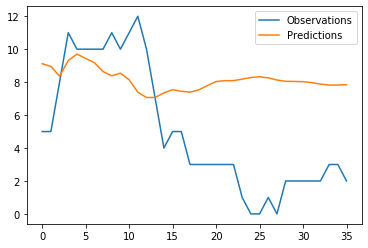

In [81]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [36]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

In [44]:
#data[22,8,2:dim(data)[3]]  #cluster==2
#x<-data[28,7,3:dim(data)[3]]   #cluster==0
x = data[21,7,]

NameError: name 'epochs' is not defined

In [62]:
X_train

array([[0.02, 0.02, 0.01, ..., 0.  , 0.  , 1.73],
       [0.02, 0.01, 0.  , ..., 0.  , 1.73, 0.09],
       [0.01, 0.  , 0.08, ..., 1.73, 0.09, 0.18],
       ...,
       [0.02, 0.01, 0.  , ..., 0.  , 0.19, 0.09],
       [0.01, 0.  , 0.31, ..., 0.19, 0.09, 0.1 ],
       [0.  , 0.31, 0.  , ..., 0.09, 0.1 , 0.  ]], dtype=float32)

In [38]:
n=30
# Set forecasting window length (in years)
m=3
# Set start year
start = 1948
origin = 1980
# Set annual sampling rate
f = 12
h = m*f

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [42]:
train_start

385

In [39]:
univariate_past_history = n*f
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(x, train_start, test_start,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(x, test_start, test_end,
                                       univariate_past_history,
                                       univariate_future_target)

In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


In [28]:
def baseline(history):
    return np.mean(history)

In [29]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [40]:
x_train_uni

array([], dtype=float64)